In [1]:
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import json

## Data Prep

In [2]:
users=pd.read_csv('user_attributes.csv')

In [3]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [4]:
bids=pd.read_csv('bid_requests.csv')

In [5]:
columns=list(json.loads(users['attributes'][0]).keys())

In [6]:
users2=pd.DataFrame(np.asarray(list(users['attributes'].apply(lambda x: sorted(json.loads(x).items()))))[:,:,1],columns=columns)
users2['user_id']=users['user_id']

In [7]:
users2['test']=users2['test'].apply(lambda x: int(x))
users2['age']=users2['age'].apply(lambda x: float(x))
users2.head()

,age,gender,location,test,user_id
0,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e
1,26.0,M,AL,1,000053b1e684c9e7ea73727b2238ce18
2,29.0,F,AR,1,00029153d12ae1c9abe59c17ff2e0895
3,29.0,M,SC,0,0002ac0d783338cfeab0b2bdbd872cda
4,27.0,F,AR,1,0004d0b59e19461ff126e3a08a814c33


In [8]:
users2=users2.drop_duplicates().reset_index(drop=True)
bids=bids.drop_duplicates().reset_index(drop=True)
final=users2.merge(bids,on='user_id',how='left')

In [9]:
bids=bids.dropna().reset_index(drop=True)
users2=users2.dropna().reset_index(drop=True)
final=final.dropna().reset_index(drop=True)
final.head()

,age,gender,location,test,user_id,timestamp,bid,win,conversion
0,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-01 13:43:34,1.0,0.0,0.0
1,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 03:59:18,0.0,0.0,0.0
2,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 17:41:50,1.0,1.0,0.0
3,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-07 04:02:42,1.0,1.0,0.0
4,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-08 09:05:01,1.0,0.0,0.0


In [10]:
test=pd.DataFrame(users2[users2['test']==1])
control=pd.DataFrame(users2[users2['test']==0])

In [22]:
test2=pd.DataFrame(final[final['test']==1])
control2=pd.DataFrame(final[final['test']==0])

## Find obvious bias

In [11]:
print('Sizes:Test {},Control {}'.format(len(test), len(control)))

Sizes:Test 56084,Control 43916


In [12]:
print('Test Gender')
test['gender'].value_counts()/len(test)

Test Gender


F    0.501177
M    0.498823
Name: gender, dtype: float64

In [13]:
print('Control Gender')
control['gender'].value_counts()/len(control)

Control Gender


M    0.503256
F    0.496744
Name: gender, dtype: float64

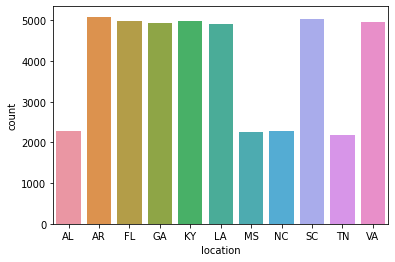

In [14]:
sb.countplot(control['location'].sort_values())

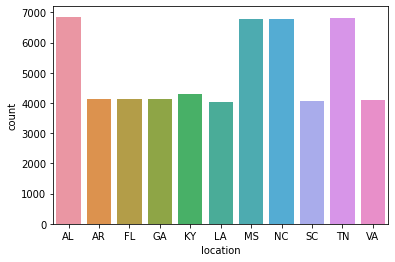

In [15]:
sb.countplot(test['location'].sort_values())

In [16]:
print('Medians: Test {},Control {}'.format(np.median(test['age']), np.median(control['age'])))
print('StandardD: Test {},Control{}'.format(np.std(test['age']),np.std(control['age'])))

Medians: Test 25.0,Control 25.0
StandardD: Test 4.6043110471866955,Control4.599852715678207


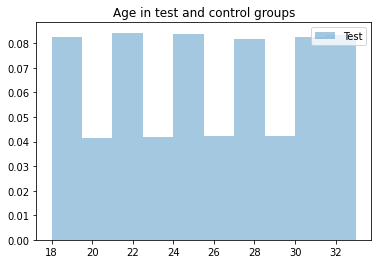

In [20]:
plt.hist(test['age'], density=True,label = "Test", alpha = .4)

plt.title('Age in test and control groups')
plt.legend(loc ='upper right')


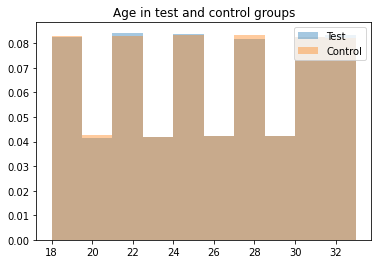

In [21]:
plt.hist(test['age'], density=True,label = "Test", alpha = .4)
plt.hist(control['age'],density=True,label = 'Control', alpha = .4)
plt.title('Age in test and control groups')
plt.legend(loc ='upper right')

The goal is to increase weekly conversions 10% in a week (with no lag) using new advertising.
A test group will be served a new advertisement and the control group will receive the old one in the same week. I'm testing the null hypothesis which says that the differences between the control and test groups are random, so the p value will be low if the differences are not random. Key metric is viewers clicking on the add and accepting the clients offer.

## Experiment results

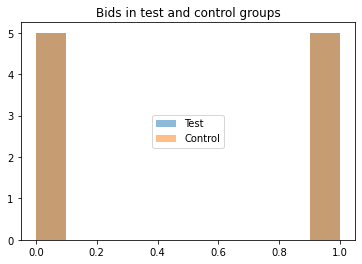

In [34]:

plt.hist(test2['bid'], density=True,label = "Test", alpha = .5)
plt.hist(control2['bid'], density=True,label = "Control", alpha = .5)
plt.title('Bids in test and control groups')
plt.legend(loc ='center')

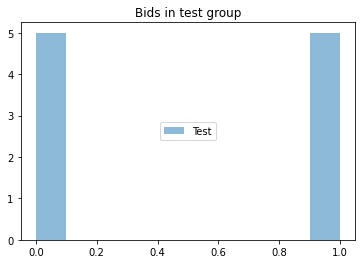

In [35]:

plt.hist(test2['bid'], density=True,label = "Test", alpha = .5)
#plt.hist(control2['bid'], density=True,label = "Control", alpha = .5)
plt.title('Bids in test group')
plt.legend(loc ='center')

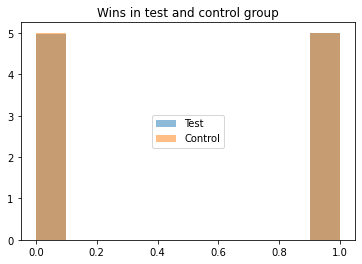

In [37]:
#only look at wins for bids
bidtest=test2[test2['bid']==1]
bidcontrol=control2[control2['bid']==1]

plt.hist(bidtest['win'], density=True,label = "Test", alpha = .5)
plt.hist(bidcontrol['win'],density=True,label = 'Control', alpha = .5)
plt.title('Wins in test and control groups')
plt.legend(loc ='center')

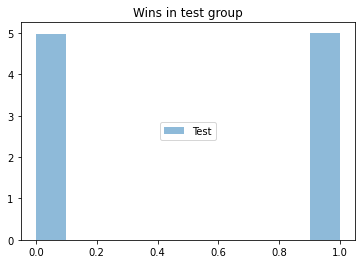

In [40]:
plt.hist(bidtest['win'], density=True,label = "Test", alpha = .5)
#plt.hist(bidcontrol['win'],density=True,label = 'Control', alpha = .5)
plt.title('Wins in test group')
plt.legend(loc ='center')

In [42]:
#only look at conversions for wins in each group
wintest=test2[test2['win']==1]
wincontrol=control2[control2['win']==1]

print("Mean Conversions in Test and Control Groups")
print('Test {},Control {}'.format(np.mean(wintest['conversion']),np.mean(wincontrol['conversion'])))

Mean Conversions in Test and Control Groups
Test 0.04009693244281577,Control 0.04153193825880056


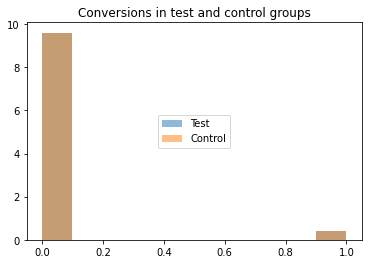

In [46]:
plt.hist(wintest['conversion'], density=True,label = "Test", alpha = .5)
plt.hist(wincontrol['conversion'],density=True,label = 'Control', alpha = .5)
plt.title('Conversions in test and control groups')
plt.legend(loc ='center')


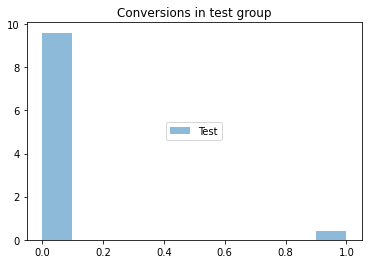

In [47]:
plt.hist(wintest['conversion'], density=True,label = "Test", alpha = .5)
#plt.hist(wincontrol['conversion'],density=True,label = 'Control', alpha = .5)
plt.title('Conversions in test group')
plt.legend(loc ='center')


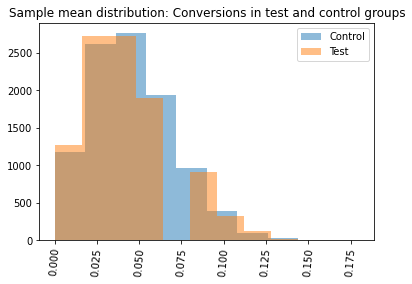

MannwhitneyuResult(statistic=2769213741.5, pvalue=0.08145325354797739)

In [48]:
#plot sample distributions and do p test
tests=[]
controls=[]


for i in range(10000):
    tes = np.random.choice(wintest['conversion'],50, replace=True).mean()
    con = np.random.choice(wincontrol['conversion'],50, replace=True).mean()
    
    controls.append(con)
    tests.append(tes)

plt.hist(controls, alpha=0.5, label='Control') 
plt.hist(tests, alpha=0.5, label='Test') 
plt.xticks(rotation=85)
plt.legend(loc='upper right')
plt.title('Sample mean distribution: Conversions in test and control groups')
plt.show()

mannwhitneyu(wintest['conversion'], wincontrol['conversion'])

In [49]:
rand1=np.random.normal(1, .5, 100)
rand1.sort()
#tests and controls
wtest=np.random.choice(tests,100)
wcontrol=np.random.choice(controls,100)
wtest.sort()
wcontrol.sort()

Text(0.5, 1.0, 'Test sample means vs normal distribution')

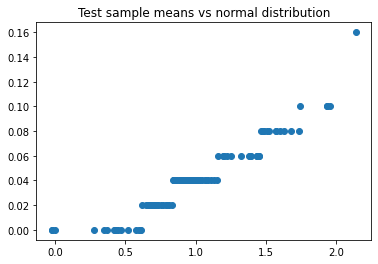

In [53]:
plt.plot(rand1,wtest,'o')
plt.title('Test sample means vs normal distribution')

Text(0.5, 1.0, 'Control sample means vs normal distribution')

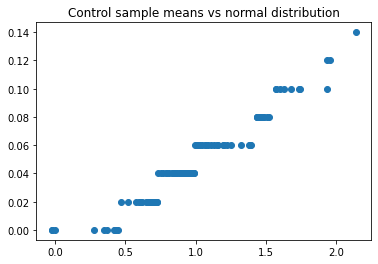

In [56]:
plt.plot(rand1,wcontrol,'o')
plt.title('Control sample means vs normal distribution')

In [52]:
1) Define a goal and create supporting hypothesis. Also define the null hypothesis that you want to negate.
2) Identify treatment and the control group. Control group is the one where people see the web-content without the new feature and the treatment groups is the one where people see it with the new feature. Also make sure that you always change only one thing between the treatment and the control group.
3) Identify the key metrics to measure, for an website some typical key metrics can be number of searches made, total time spent by an user, click through rate etc.
4) Identify which data do we need to collect to successfully run the test, e.g. User id, cookie id, page loads, any engagement at the web page etc.
5) Make sure to enable logging everywhere , e.g. what happens if we press back button or log-out from the page etc.
6) Decide how much difference do we need to detect in order to consider it is worth investing in the experiment. e.g we want to track an increase of 5% in total time spent by users between the treatment and the control group.
7)What fraction of total visitors do we want to be in our treatment group ?
8) Using the power test decide how much data do we need to collect. Please check the related function in python here.
9) Decide duration of the test, e.g. if you experience around 1000 unique users per day and if from 8 you identify around 50,000 people to be needed to successfully conduct the experiment then you need to run this experiment for at-least 50,000/1000 = 50 days.
10) Run a dummy A/A test where the control and the treatment groups are the same. This step is suggested to identify if there is any systematic bias in the experiment.



SyntaxError: unmatched ')' (<ipython-input-52-fda838e11c5d>, line 1)